In [1]:
#pip install numpy==1.23.5

In [2]:
#pip install pandas==2.2.2

In [3]:
#pip install matplotlib seaborn

In [4]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!pip install distributed

Defaulting to user installation because normal site-packages is not writeable


In [6]:
pip show numpy

Name: numpy
Version: 1.26.4
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2023, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYR

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
import os
import warnings

# Ignore specific warning category
warnings.filterwarnings("ignore", category=DeprecationWarning)

#import dask.dataframe as dd

#print(os.getcwd())
df = pd.read_csv(r"C:\Users\manoj\Downloads\US_Accidents_March23.csv\US_Accidents_March23.csv")
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [9]:

# Step 1: Drop unnecessary columns
columns_to_drop = ['ID',
    'City', 'Amenity', 'Railway', 'Timezone', 'No_Exit', 'Traffic_Calming',
    'Turning_Loop', 'Roundabout', 'Bump', 'Source', 'Street',
    'Zipcode', 'County', 'Country', 'Airport_Code', 'Description'
]
df = df.drop(columns=columns_to_drop, errors='ignore')

# Step 2: Handle missing values
numerical_cols = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
                  'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
                  'Precipitation(in)']
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

categorical_cols = ['Civil_Twilight', 'Weather_Timestamp', 'Weather_Condition',
                    'Sunrise_Sunset', 'Nautical_Twilight', 'Astronomical_Twilight']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# Impute missing values for End_Lat and End_Lng using Start_Lat and Start_Lng
df['End_Lat'] = df['End_Lat'].fillna(df['Start_Lat'])
df['End_Lng'] = df['End_Lng'].fillna(df['Start_Lng'])

# Fill missing values for Wind_Direction with 'Unknown'
df['Wind_Direction'] = df['Wind_Direction'].fillna('Unknown')

# Step 3: Convert datetime columns to Unix timestamps
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

df['Start_Time'] = df['Start_Time'].apply(lambda x: x.timestamp() if pd.notnull(x) else None)
df['End_Time'] = df['End_Time'].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

# Step 4: Encode categorical columns
from sklearn.preprocessing import LabelEncoder

categorical_columns = [
    'ID', 'Start_Time', 'End_Time', 'State', 'Weather_Timestamp',
    'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset',
    'Nautical_Twilight', 'Astronomical_Twilight', 'Crossing',
    'Give_Way', 'Junction', 'Station', 'Stop', 'Traffic_Signal', 'Civil_Twilight'
]
columns_to_encode = ['State', 'Weather_Condition', 'Wind_Direction']
label_encoded_columns = [col for col in categorical_columns if col not in columns_to_encode]

label_encoder = LabelEncoder()
for col in label_encoded_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))

df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

# Step 5: Verify the updated DataFrame
print("\nUpdated DataFrame Schema:")
print(df.info())

# Step 6: Check for remaining missing values
print("\nMissing Values After Handling:")
print(df.isnull().sum())



Updated DataFrame Schema:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Columns: 242 entries, Severity to Wind_Direction_West
dtypes: bool(216), float64(12), int32(13), int64(1)
memory usage: 2.7 GB
None

Missing Values After Handling:
Severity                   0
Start_Time                 0
End_Time                   0
Start_Lat                  0
Start_Lng                  0
                          ..
Wind_Direction_Variable    0
Wind_Direction_W           0
Wind_Direction_WNW         0
Wind_Direction_WSW         0
Wind_Direction_West        0
Length: 242, dtype: int64


In [10]:
# Assuming df is your DataFrame
print("Column Names and Data Types:")
print(df.dtypes)

Column Names and Data Types:
Severity                     int64
Start_Time                   int32
End_Time                     int32
Start_Lat                  float64
Start_Lng                  float64
                            ...   
Wind_Direction_Variable       bool
Wind_Direction_W              bool
Wind_Direction_WNW            bool
Wind_Direction_WSW            bool
Wind_Direction_West           bool
Length: 242, dtype: object


In [11]:
# Check the shape of the dataset
print("Dataset Shape:", df.shape)


# Compute the missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Dataset Shape: (7728394, 242)
Missing Values:
 Series([], dtype: int64)


In [12]:
pip install --upgrade pyarrow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
# Identify numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical Columns:", numerical_columns)

# Identify categorical columns based on data types
string_columns = df.select_dtypes(include=['object']).columns.tolist()  # Changed from 'string[pyarrow]' to 'object'
bool_columns = df.select_dtypes(include=['bool']).columns.tolist()

# Combine both lists
categorical_columns = string_columns + bool_columns

# Print the identified categorical columns
print("Categorical Columns:", categorical_columns)


Numerical Columns: ['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
Categorical Columns: ['State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY', 'Weather_Condition_Blowing Dust / Windy', 'Weather_Condition_Blowing Sand', 'Weather_Condition_Blowing Snow', 'Weather_Condition_Blowing Snow / Windy', 'Weather_Condition_Blowing Sno

In [14]:
print(df['Severity'].value_counts())

Severity
2    6156981
3    1299337
4     204710
1      67366
Name: count, dtype: int64


In [15]:
# Check the data types of the columns
print("Data types of columns after encoding:")
print(df.dtypes)

Data types of columns after encoding:
Severity                     int64
Start_Time                   int32
End_Time                     int32
Start_Lat                  float64
Start_Lng                  float64
                            ...   
Wind_Direction_Variable       bool
Wind_Direction_W              bool
Wind_Direction_WNW            bool
Wind_Direction_WSW            bool
Wind_Direction_West           bool
Length: 242, dtype: object



Class Distribution:
Severity
2    6156981
3    1299337
4     204710
1      67366
Name: count, dtype: int64


C:\Users\manoj\AppData\Local\Temp\ipykernel_15740\3793978917.py:26: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  barplot = sns.barplot(data=class_df, x='Severity', y='Count', hue='Severity', palette=palette, legend=False)


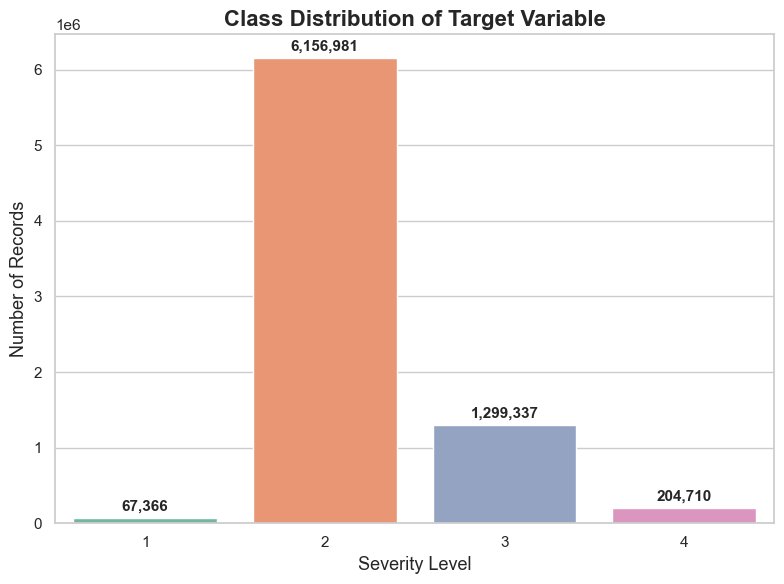

In [16]:
# Check the distribution of the target variable
target_column = 'Severity'  # Replace with your actual target column name
class_distribution = df[target_column].value_counts()

print("\nClass Distribution:")
print(class_distribution)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data
target_column = 'Severity'
class_distribution = df[target_column].value_counts().sort_index()
class_df = pd.DataFrame({
    'Severity': class_distribution.index,
    'Count': class_distribution.values
})

# Set the style and palette
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

# Create the plot
plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=class_df, x='Severity', y='Count', hue='Severity', palette=palette, legend=False)

# Annotate the bars
for i, count in enumerate(class_df['Count']):
    barplot.text(i, count + max(class_df['Count'])*0.01, f'{count:,}', 
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

# Titles and labels
plt.title("Class Distribution of Target Variable", fontsize=16, fontweight='bold')
plt.xlabel("Severity Level", fontsize=13)
plt.ylabel("Number of Records", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()



In [17]:
from imblearn.under_sampling import RandomUnderSampler

# Step 7: Separate features and target
target_column = 'Severity'  # Replace with your actual target column name
X = df.drop(columns=[target_column])
y = df[target_column]


# Define the undersampler
undersampler = RandomUnderSampler(random_state=42)

# Apply undersampling
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Check the new class distribution
print("\nClass Distribution After Undersampling:")
print(pd.Series(y_resampled).value_counts())



Class Distribution After Undersampling:
Severity
1    67366
2    67366
3    67366
4    67366
Name: count, dtype: int64


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 8: Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,shuffle = True, test_size=0.2, random_state=42)

# Step 9: Train a Random Forest model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Step 10: Make predictions
y_pred = rf_clf.predict(X_test)

# Step 11: Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))



Confusion Matrix:
[[12862   248   244   120]
 [  362  8445  2494  2061]
 [  605  1075 10251  1536]
 [  188  1617   681 11104]]

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.95      0.94     13474
           2       0.74      0.63      0.68     13362
           3       0.75      0.76      0.76     13467
           4       0.75      0.82      0.78     13590

    accuracy                           0.79     53893
   macro avg       0.79      0.79      0.79     53893
weighted avg       0.79      0.79      0.79     53893


Accuracy Score:
0.7916055888519845


In [19]:
from sklearn.ensemble import GradientBoostingClassifier

# Train a Gradient Boosting model
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = gb_clf.predict(X_test)
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred))



Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.94      0.91     13474
           2       0.73      0.50      0.60     13362
           3       0.72      0.71      0.72     13467
           4       0.67      0.83      0.74     13590

    accuracy                           0.75     53893
   macro avg       0.75      0.75      0.74     53893
weighted avg       0.75      0.75      0.74     53893



In [20]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Adjust y_train and y_test to start from 0 if necessary
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Train an XGBoost model without the use_label_encoder parameter
xgb_clf = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train_adjusted)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
print("\nXGBoost Classification Report:")
print(classification_report(y_test_adjusted, y_pred))





XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     13474
           1       0.75      0.62      0.68     13362
           2       0.74      0.76      0.75     13467
           3       0.74      0.81      0.77     13590

    accuracy                           0.79     53893
   macro avg       0.79      0.79      0.78     53893
weighted avg       0.79      0.79      0.78     53893



In [22]:
from sklearn.linear_model import LogisticRegression

# Step 7: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Step 8: Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Step 9: Train a Logistic Regression model
lr_clf = LogisticRegression(max_iter=500, random_state=42)  # Increased max_iter
lr_clf.fit(X_train, y_train)


# Evaluate the model
y_pred = lr_clf.predict(X_test)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.79      0.71     13474
           2       0.54      0.36      0.43     13362
           3       0.54      0.64      0.59     13467
           4       0.58      0.53      0.55     13590

    accuracy                           0.58     53893
   macro avg       0.58      0.58      0.57     53893
weighted avg       0.58      0.58      0.57     53893



In [23]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 15.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [24]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(random_state=42)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
print(classification_report(y_test, y_pred))


C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3327
[LightGBM] [Info] Number of data points in the train set: 215571, number of used features: 148
[LightGBM] [Info] Start training from score -1.386308
[LightGBM] [Info] Start training from score -1.384232
[LightGBM] [Info] Start training from score -1.386178
[LightGBM] [Info] Start training from score -1.388463
              precision    recall  f1-score   support

           1       0.91      0.95      0.93     13474
           2       0.74      0.61      0.67     13362
           3       0.74      0.75      0.75     13467
           4       0.73      0.82      0.77     13590

    accuracy                           0.78     53893
   macro avg       0.78      0.78      0.78     53893
weighted avg       0.78      0.78      0.78     5

In [25]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
    --------------------------------------- 2.1/102.4 MB 13.0 MB/s eta 0:00:08
   - -------------------------------------- 5.0/102.4 MB 13.1 MB/s eta 0:00:08
   --- ------------------------------------ 8.4/102.4 MB 13.7 MB/s eta 0:00:07
   ---- ----------------------------------- 11.8/102.4 MB 14.2 MB/s eta 0:00:07
   ----- ---------------------------------- 14.4/102.4 MB 13.9 MB/s eta 0:00:07
   ------ --------------------------------- 17.6/102.4 MB 13.8 MB/s eta 0:00:07
   -------- ------------------------------- 20.7/102.4 MB 13.9 MB/s eta 0:00:06
   --------- ------------------------------ 23.9/102.4 MB 14.0 MB/s eta 0:00:06
   ---------- ----------------------------- 26.5/102.4 MB 13.9 MB/s eta 0:00:06
   ----------- ---------------------------- 28.8/102.4 MB 13.6 MB/s eta 0:00:06
   ------------ --------------------------- 31.5/102.4

In [ ]:
from catboost import CatBoostClassifier
cat_clf = CatBoostClassifier(random_state=42, verbose=0)
cat_clf.fit(X_train, y_train)
y_pred = cat_clf.predict(X_test)
print(classification_report(y_test, y_pred))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Create and fit the Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42, eval_metric='mlogloss')),
    ('gb', GradientBoostingClassifier(random_state=42))
], voting='soft')

voting_clf.fit(X_train, y_train)

# Access feature importances from the Random Forest model
importances = voting_clf.estimators_[0].feature_importances_  # Example for Random Forest
plt.barh(range(len(importances)), importances)
plt.show()



In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Create a Voting Classifier with Random Forest, XGBoost, and Gradient Boosting
voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42, eval_metric='mlogloss')),
    ('gb', GradientBoostingClassifier(random_state=42))
], voting='soft')

# Fit the Voting Classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))




In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler


# Step 4: Create new features
# Create all new features in a separate DataFrame
new_features = pd.DataFrame()

# Distance binning
new_features['Distance_Category'] = pd.cut(
    X_resampled['Distance(mi)'], bins=[0, 1, 5, 10, 50], labels=['Short', 'Medium', 'Long', 'Very Long']
)

# Extreme weather conditions
new_features['Extreme_Temperature'] = (X_resampled['Temperature(F)'] > 100) | (X_resampled['Temperature(F)'] < 32)
new_features['High_Wind'] = X_resampled['Wind_Speed(mph)'] > 30

# Time-based features
X_resampled['Start_Time'] = pd.to_datetime(X_resampled['Start_Time'])
new_features['Start_Hour'] = X_resampled['Start_Time'].dt.hour
new_features['Start_Day'] = X_resampled['Start_Time'].dt.dayofweek
new_features['Is_Weekend'] = new_features['Start_Day'].isin([5, 6])

# Interaction features
new_features['Temp_Humidity_Interaction'] = X_resampled['Temperature(F)'] * X_resampled['Humidity(%)']

# Step 5: Concatenate new features with the original DataFrame
X_resampled = pd.concat([X_resampled.reset_index(drop=True), new_features.reset_index(drop=True)], axis=1)

# Step 6: Normalize numerical features
scaler = MinMaxScaler()
numerical_features = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Wind_Speed(mph)']
X_resampled[numerical_features] = scaler.fit_transform(X_resampled[numerical_features])


# Step 10: Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Step 11: Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Step 3: Create new features
X_resampled['Distance_Category'] = pd.cut(
    X_resampled['Distance(mi)'], bins=[0, 1, 5, 10, 50], labels=['Short', 'Medium', 'Long', 'Very Long']
)
X_resampled['Extreme_Temperature'] = (X_resampled['Temperature(F)'] > 100) | (X_resampled['Temperature(F)'] < 32)
X_resampled['High_Wind'] = X_resampled['Wind_Speed(mph)'] > 30
X_resampled['Start_Hour'] = pd.to_datetime(X_resampled['Start_Time']).dt.hour
X_resampled['Start_Day'] = pd.to_datetime(X_resampled['Start_Time']).dt.dayofweek
X_resampled['Is_Weekend'] = X_resampled['Start_Day'].isin([5, 6])
X_resampled['Temp_Humidity_Interaction'] = X_resampled['Temperature(F)'] * X_resampled['Humidity(%)']

# Step 4: Drop low-importance features
low_importance_features = [
    'Weather_Condition_Heavy Rain Showers',
    'Weather_Condition_Heavy Thunderstorms with Small Hail',
    'Weather_Condition_Light Snow Grains',
    # Add other features with zero importance
]
X_resampled = X_resampled.drop(columns=low_importance_features, errors='ignore')

# Step 5: Normalize numerical features
numerical_features = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Wind_Speed(mph)']
scaler = MinMaxScaler()
X_resampled[numerical_features] = scaler.fit_transform(X_resampled[numerical_features])

# Step 6: Encode categorical features
encoder = OneHotEncoder(sparse=False, drop='first')  # Use one-hot encoding
encoded_categories = encoder.fit_transform(X_resampled[['Distance_Category']])
encoded_category_df = pd.DataFrame(
    encoded_categories, 
    columns=encoder.get_feature_names_out(['Distance_Category'])
)

# Add encoded columns to the dataset and drop the original categorical column
X_resampled = pd.concat([X_resampled.reset_index(drop=True), encoded_category_df], axis=1)
X_resampled = X_resampled.drop(columns=['Distance_Category'])

# Step 7: Prepare data for modeling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 8: Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Step 9: Evaluate model
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

# Step 10: Get feature importance
log_reg_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(log_reg.coef_[0])
}).sort_values(by='Importance', ascending=False)

print("Logistic Regression Feature Importance:")
print(log_reg_importance)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler

# Step 1: Separate features and target
target_column = 'Severity'  # Replace with your actual target column name
X = df.drop(columns=[target_column])
y = df[target_column]

# Step 2: Handle class imbalance (undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Step 3: Feature Engineering (optimized to avoid fragmentation)
new_features = pd.DataFrame({
    'Distance_Category': pd.cut(
        X_resampled['Distance(mi)'], bins=[0, 1, 5, 10, 50], labels=['Short', 'Medium', 'Long', 'Very Long']
    ),
    'Extreme_Temperature': (X_resampled['Temperature(F)'] > 100) | (X_resampled['Temperature(F)'] < 32),
    'High_Wind': X_resampled['Wind_Speed(mph)'] > 30,
    'Start_Hour': pd.to_datetime(X_resampled['Start_Time']).dt.hour,
    'Start_Day': pd.to_datetime(X_resampled['Start_Time']).dt.dayofweek,
    'Is_Weekend': pd.to_datetime(X_resampled['Start_Time']).dt.dayofweek.isin([5, 6]),
    'Temp_Humidity_Interaction': X_resampled['Temperature(F)'] * X_resampled['Humidity(%)']
})

# Concatenate new features with the original DataFrame
X_resampled = pd.concat([X_resampled, new_features], axis=1)

# Step 4: Drop low-importance features
low_importance_features = [
    'Weather_Condition_Heavy Rain Showers',
    'Weather_Condition_Heavy Thunderstorms with Small Hail',
    'Weather_Condition_Light Snow Grains',
    # Add other features with zero importance
]
X_resampled = X_resampled.drop(columns=low_importance_features, errors='ignore')

# Step 5: Normalize numerical features
numerical_features = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Wind_Speed(mph)']
scaler = MinMaxScaler()
X_resampled[numerical_features] = scaler.fit_transform(X_resampled[numerical_features])

# Step 6: Encode categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Updated to use sparse_output
encoded_categories = encoder.fit_transform(X_resampled[['Distance_Category']])
encoded_category_df = pd.DataFrame(
    encoded_categories, 
    columns=encoder.get_feature_names_out(['Distance_Category'])
)

# Add encoded columns to the dataset and drop the original categorical column
X_resampled = pd.concat([X_resampled.reset_index(drop=True), encoded_category_df], axis=1)
X_resampled = X_resampled.drop(columns=['Distance_Category'])

# Step 7: Adjust target variable to start from 0
y_resampled = y_resampled - y_resampled.min()

# Step 8: Prepare data for modeling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 9: Train XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,  # Number of trees
    max_depth=6,       # Maximum depth of each tree
    learning_rate=0.1, # Learning rate
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Step 10: Evaluate the model
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Step 11: Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance:")
print(feature_importance)


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Adjust target variable to start from 0
y_resampled = y_resampled - y_resampled.min()

# Define a function to perform RFECV and train the model
def perform_rfecv_and_train(model, model_name, X, y, step=2, cv=3):
    print(f"\nPerforming RFECV for {model_name}...")
    
    # Step 1: Initialize RFECV
    rfecv = RFECV(
        estimator=model,
        step=step,  # Number of features to remove at each iteration
        cv=StratifiedKFold(cv),  # Cross-validation folds
        scoring='accuracy',  # Metric to evaluate performance
        n_jobs=-1  # Use all available cores
    )
    
    # Step 2: Fit RFECV to the data
    rfecv.fit(X, y)
    
    # Step 3: Get selected features
    selected_features = X.columns[rfecv.support_]
    print(f"Optimal Number of Features for {model_name}: {rfecv.n_features_}")
    print(f"Selected Features for {model_name}: {list(selected_features)}")
    
    # Step 4: Train and evaluate the model with selected features
    X_selected = X[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    return selected_features

# Step 5: Perform RFECV and train models
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_selected_features = perform_rfecv_and_train(rf_model, "Random Forest", X_resampled, y_resampled, step=2, cv=3)

# XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_selected_features = perform_rfecv_and_train(xgb_model, "XGBoost", X_resampled, y_resampled, step=2, cv=3)

# CatBoost
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_selected_features = perform_rfecv_and_train(catboost_model, "CatBoost", X_resampled, y_resampled, step=2, cv=3)

# Step 6: Compare Selected Features
common_selected_features = set(rf_selected_features) & set(xgb_selected_features) & set(catboost_selected_features)
print(f"\nCommon Selected Features Across Models: {list(common_selected_features)}")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Use the common selected features
X_reduced = X_resampled[['Astronomical_Twilight', 'Start_Lat', 'State_NC', 'State_TX', 'Distance(mi)', 
 'State_GA', 'Traffic_Signal', 'Start_Lng', 'Weather_Timestamp', 'Junction', 
 'State_CA', 'ID', 'End_Time', 'State_MN', 'Start_Time', 'End_Lng', 'Stop', 
 'Crossing', 'State_SC', 'End_Lat']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))



In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Use the common selected features
X_reduced = X_resampled[['Astronomical_Twilight', 'Start_Lat', 'State_NC', 'State_TX', 'Distance(mi)', 
 'State_GA', 'Traffic_Signal', 'Start_Lng', 'Weather_Timestamp', 'Junction', 
 'State_CA', 'ID', 'End_Time', 'State_MN', 'Start_Time', 'End_Lng', 'Stop', 
 'Crossing', 'State_SC', 'End_Lat']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Use the common selected features
X_reduced = X_resampled[['Astronomical_Twilight', 'Start_Lat', 'State_NC', 'State_TX', 'Distance(mi)', 
 'State_GA', 'Traffic_Signal', 'Start_Lng', 'Weather_Timestamp', 'Junction', 
 'State_CA', 'ID', 'End_Time', 'State_MN', 'Start_Time', 'End_Lng', 'Stop', 
 'Crossing', 'State_SC', 'End_Lat']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the CatBoost model
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Evaluate the model
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform Randomized Search
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    cv=3,       # 3-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)
print("Best Parameters for Random Forest:", rf_random_search.best_params_)

# Evaluate the tuned model
best_rf_model = rf_random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'max_depth': [3, 5, 7, 10],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for training each tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used for training each tree
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a split
}

# Initialize the XGBoost classifier without the use_label_encoder parameter
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Initialize RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    scoring='accuracy',  # Metric to optimize
    cv=3,  # 3-fold cross-validation
    verbose=2,  # Print progress
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to the data
xgb_random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters for XGBoost:", xgb_random_search.best_params_)
print("Best Cross-Validation Accuracy:", xgb_random_search.best_score_)

# Evaluate the best model on the test set
best_xgb_model = xgb_random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)
print("Classification Report for Tuned XGBoost:")
print(classification_report(y_test, y_pred))


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Define the parameter grid for CatBoost (with subsample and bootstrap_type)
param_grid = {
    'iterations': [100, 200, 300, 400, 500],  # Number of boosting iterations
    'depth': [3, 4, 5, 6, 7, 8],  # Depth of the trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # L2 regularization coefficient
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for training each tree
    'colsample_bylevel': [0.6, 0.8, 1.0],  # Fraction of features used for training each tree
    'bootstrap_type': ['Bernoulli'],  # Set bootstrap type to Bernoulli
}

# Initialize the CatBoost classifier
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# Initialize RandomizedSearchCV
catboost_random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    scoring='accuracy',  # Metric to optimize
    cv=3,  # 3-fold cross-validation
    verbose=2,  # Print progress
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to the data
catboost_random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters for CatBoost:", catboost_random_search.best_params_)
print("Best Cross-Validation Accuracy:", catboost_random_search.best_score_)

# Evaluate the best model on the test set
best_catboost_model = catboost_random_search.best_estimator_
y_pred = best_catboost_model.predict(X_test)
print("Classification Report for Tuned CatBoost:")
print(classification_report(y_test, y_pred))


In [ ]:
pip install xgboost[gpu]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt

# Load your dataset
# Replace this with your actual data loading
# X, y = load_your_data()

# Example: Create a sample dataset (uncomment and replace with your data)
# X = pd.DataFrame(np.random.rand(1000, 10))  # 1000 samples, 10 features
# y = np.random.randint(-1, 4, size=1000)  # Class labels from -1 to 3

# Check the unique values in y
print("Unique values in y before relabeling:", np.unique(y))

# Ensure all labels are non-negative and start from 0
if np.min(y) < 0:
    # Shift labels to make them non-negative
    y = y - np.min(y)  # This will shift the minimum value to 0
print("Unique values in y after relabeling:", np.unique(y))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
}

# Initialize the XGBoost classifier without GPU acceleration
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Initialize RandomizedSearchCV with fewer iterations and folds
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Reduced iterations
    scoring='accuracy',
    cv=2,  # Reduced folds
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV to the data
xgb_random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters for XGBoost:", xgb_random_search.best_params_)
print("Best Cross-Validation Accuracy:", xgb_random_search.best_score_)

# Evaluate the best model on the test set
best_xgb_model = xgb_random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)

# Classification Report
print("Classification Report for Tuned XGBoost:")
print(classification_report(y_test, y_pred))

# F1-Score for Class 1
f1_class_1 = f1_score(y_test, y_pred, average=None)[1]  # F1-score for class 1
print(f"F1-Score for Class 1: {f1_class_1:.4f}")

# ROC-AUC Score (Multi-Class)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC-AUC Score (Multi-Class): {roc_auc:.4f}")



# Save the best model for future use
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Make sure to install this library

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_xgb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Tuned XGBoost")
plt.show()

# Feature Importance Analysis
importances = best_xgb_model.feature_importances_
feature_names = X.columns  # Assuming X is a DataFrame
sorted_indices = np.argsort(importances)

# Limit to top N features (e.g., top 10)
top_n = 20
sorted_indices = sorted_indices[-top_n:]  # Get indices of top N features

# Plot feature importance
plt.figure(figsize=(20, 10))  # Increased figure size
plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), feature_names[sorted_indices])

# Adding text labels
for i, v in enumerate(importances[sorted_indices]):
    plt.text(v + 0.01, i, f"{feature_names[sorted_indices][i]}: {v:.2f}", va='center')

plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()




In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['Random Forest', 'XGBoost', 'CatBoost']

# Accuracy values from your results
accuracies = [0.81, 0.86, 0.81]  # Random Forest, XGBoost, and CatBoost accuracies

# F1-scores for class 1 from your results
f1_scores = [0.72, 0.92, 0.71]  # F1-scores for class 1 for Random Forest, XGBoost, and CatBoost

# Create a bar chart for accuracy and F1-score
plt.figure(figsize=(10, 5))

# Set the bar width
bar_width = 0.35
x = range(len(models))

# Create bars for accuracy
plt.bar(x, accuracies, width=bar_width, color='skyblue', alpha=0.7, label='Accuracy')

# Create bars for F1-score, offsetting them by the width of the bars
plt.bar([p + bar_width for p in x], f1_scores, width=bar_width, color='salmon', alpha=0.7, label='F1-Score for Class 1')

# Adding labels and title
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy and F1-Score for Class 1')
plt.xticks([p + bar_width / 2 for p in x], models)  # Center the x-tick labels
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits
plt.grid(axis='y')  # Add grid lines for better readability
plt.show()



In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC for each model
def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 6))
plot_roc_curve(y_test, best_xgb_model.predict_proba(X_test), 'XGBoost')
# Repeat for other models if you have their predictions
# plot_roc_curve(y_test, rf_pred_proba, 'Random Forest')
# plot_roc_curve(y_test, catboost_pred_proba, 'CatBoost')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output (one-vs-rest) for multi-class Precision-Recall
n_classes = len(np.unique(y_test))  # Number of classes
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

# Calculate Precision-Recall curve and Average Precision for each class
precision = {}
recall = {}
average_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])

# Plot the Precision-Recall curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class XGBoost')
plt.legend(loc='best')
plt.grid()
plt.show()
